# A/B - test

Итак... Проверим **Гипотезу 7.** Добавить возможность издателям добавлять свои "Платные элементы" в блок "Это интересно" за дополнительную плату, что увеличит общую выручку на 15%

Или:

H0: Добавить возможность издателям добавлять свои "Платные элементы" в блок "Это интересно" за дополнительную плату, не увеличит общую выручку

H1: Добавить возможность издателям добавлять свои "Платные элементы" в блок "Это интересно" за дополнительную плату, что увеличит общую выручку на 15%

После проведения теста, у нас есть файл с результатами `AB_Test_revenue_only.csv`

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import hashlib

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# прочитаем данные
path = 'AB_Test_revenue_only.csv'
df = pd.read_csv(path, sep=';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       10000 non-null  int64  
 1   variant_name  10000 non-null  object 
 2   revenue       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [4]:
df.head(3)

,user_id,variant_name,revenue
0,9468,control,8.528105
1,9446,control,5.800314
2,8872,control,6.957476


1. Проверим пересечения групп. Посчитаем количество уникальных групп для каждого участника и посмотрим общее количество пользователей, попавших в обе группы, т.е. у которых это количество > 1

In [5]:
user_group_counts = df.groupby('user_id')['variant_name'].nunique()
user_group_counts

user_id
2        1
3        2
4        1
5        1
6        1
        ..
9993     1
9995     1
9996     2
9998     1
10000    2
Name: variant_name, Length: 6324, dtype: int64

In [6]:
users_in_multiple_groups = user_group_counts[user_group_counts > 1]
users_in_multiple_groups

user_id
3        2
10       2
18       2
25       2
40       2
        ..
9978     2
9979     2
9982     2
9996     2
10000    2
Name: variant_name, Length: 1541, dtype: int64

In [7]:
num_users_in_multiple_groups = len(users_in_multiple_groups)
num_users_in_multiple_groups

1541

2. Создаем множества (sets) для каждой группы пользователей (A и B) и найдём пересечение множеств для пользователей, входящих и в группу A, и в группу B

In [8]:
users_in_group_A = set(df[df['variant_name'] == 'control']['user_id'])
users_in_group_B = set(df[df['variant_name'] == 'variant']['user_id'])

In [9]:
users_in_both_groups = users_in_group_A.intersection(users_in_group_B)

# Выводим результат
print(f"Количество пользователей, входящих в обе группы: {len(users_in_both_groups)}")

# Выводим пример пользователей, входящих в обе группы
print("Пример пользователей, входящих в обе группы:")
print(users_in_both_groups)

Количество пользователей, входящих в обе группы: 1541
Пример пользователей, входящих в обе группы:
{8192, 3, 8198, 8199, 10, 18, 25, 8220, 8223, 40, 57, 60, 8252, 64, 67, 8267, 8271, 8275, 8278, 86, 8281, 8287, 98, 8293, 104, 8300, 110, 8303, 114, 8310, 8316, 8322, 140, 144, 8339, 8340, 151, 152, 8347, 155, 8349, 158, 162, 8359, 171, 8366, 8370, 186, 187, 194, 8389, 203, 8396, 206, 208, 212, 8406, 218, 8413, 8416, 225, 8419, 8424, 239, 8432, 8437, 245, 250, 8448, 256, 8452, 263, 268, 8462, 8469, 8471, 8474, 284, 8478, 287, 8479, 8484, 292, 298, 303, 8496, 306, 307, 8498, 8501, 311, 8505, 8510, 8517, 333, 334, 335, 8527, 8530, 342, 345, 346, 8542, 351, 362, 364, 8558, 368, 8561, 370, 8564, 8566, 377, 8570, 8571, 8572, 8575, 384, 8579, 8581, 393, 8587, 395, 8589, 8591, 402, 403, 405, 8599, 8604, 413, 416, 8609, 8614, 8619, 427, 8621, 441, 8634, 442, 444, 8640, 8643, 8644, 456, 457, 8653, 464, 8660, 8664, 8672, 8676, 8684, 500, 8696, 8698, 8700, 8704, 8705, 8710, 8717, 537, 8730, 539, 542

Для очистки выбросов можно написать функцию и проанализировать, сколько данных срезается, если ее использовать. Если удаляется более 1-5% данных, то можно регулировать значения перцентилей под вашу задачу.

Эта функция удаляет значения, выходящие за пределы интерквартильного диапазона:

In [10]:
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

      # Сохраняем только данные, которые не являются выбросами
    cleaned_data = data[(data > lower_bound) & (data < upper_bound)]

    return cleaned_data

Пример использования этой функции:

In [11]:
data = np.array([1, 2, 3, 5, 1000, 7, 8])
cleaned_data = remove_outliers_iqr(data)
percent_removed = ((len(data) - len(cleaned_data)) / len(data)) * 100
print("Очищенные данные:", cleaned_data)
print("Процент удаленных данных: {:.2f}%".format(percent_removed))

Очищенные данные: [1 2 3 5 7 8]
Процент удаленных данных: 14.29%


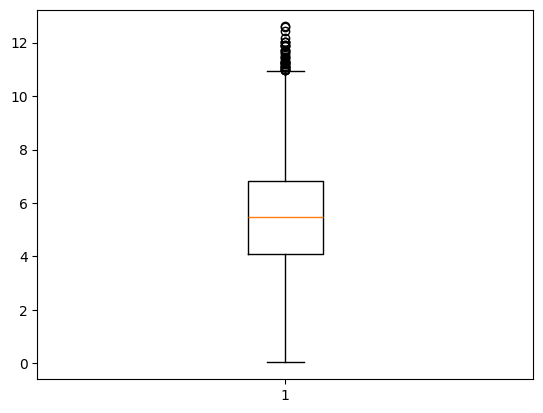

In [12]:
plt.boxplot(df['revenue'])
plt.show()

Можно создать новый датафрейм без выбросов с помощью функции выше:

In [13]:
cleaned_revenue = remove_outliers_iqr(df['revenue'])
df_cleaned = df.loc[cleaned_revenue.index]

> Замечание:
>
> Возвращается новый Series только с невыбросными значениями
>
> Этот Series сохраняет оригинальные индексы из датафрейма df
>
> Метод .loc[] выбирает строки датафрейма по указанным индексам
>
> Выбираются только те строки, индексы которых есть в cleaned_revenue.index
>
> Сохраняются ВСЕ столбцы датафрейма для этих строк

In [14]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9962 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       9962 non-null   int64  
 1   variant_name  9962 non-null   object 
 2   revenue       9962 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 311.3+ KB


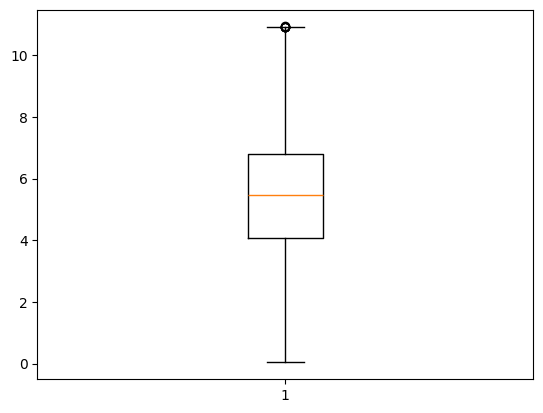

In [15]:
plt.boxplot(df_cleaned['revenue'])
plt.show()

Перепишем эту функцию, чтобы она была применима к датафрейму:

In [16]:
def remove_outliers_iqr_from_df(df, column_name):
    Q1 = np.percentile(df[column_name], 25)
    Q3 = np.percentile(df[column_name], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Возвращаем отфильтрованный датафрейм
    return df[(df[column_name] > lower_bound) & (df[column_name] < upper_bound)]

In [17]:
# Использование
df_cleaned2 = remove_outliers_iqr_from_df(df, 'revenue')
df_cleaned2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9962 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       9962 non-null   int64  
 1   variant_name  9962 non-null   object 
 2   revenue       9962 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 311.3+ KB


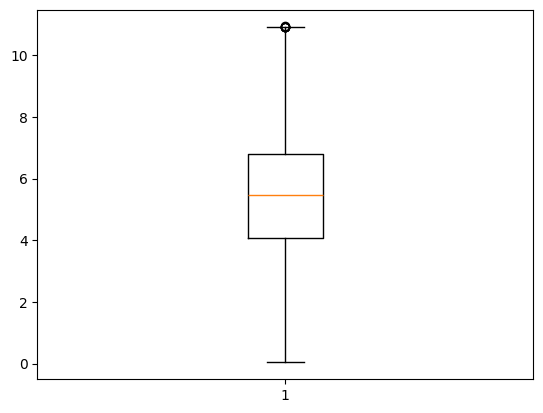

In [18]:
plt.boxplot(df_cleaned2['revenue'])
plt.show()

Проведем тест на равенство средних (средняя выручка). Применим t-критерий

In [31]:
control = df_cleaned2[df_cleaned2['variant_name'] == 'control']['revenue']
variant = df_cleaned2[df_cleaned2['variant_name'] == 'variant']['revenue']

In [32]:
ttest_pvalue = stats.ttest_ind(control, variant, alternative='less').pvalue
ttest_pvalue

np.float64(4.7482293752218206e-129)

p-value очень близок к 0, значит H0 отвергаем.

Посмотрим на сколько изменилась средняя выручка:

In [43]:
M_control = control.mean()
M_variant = variant.mean()
diff = (M_variant - M_control)/M_control * 100
print(f'{diff:.2f}%')

19.14%


Вывод: гипотеза верная, она привела к увеличению средней выручки

In [46]:
M_control

np.float64(4.969289198975206)